# This task involves fetching the latest TCGA data for somatic variants found in the genomes of colon cancer patients, cleaning it up, and performing some analysis on it.

In [1]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import gzip
import numpy as np
import pandas as pd

Filter out irregular samples, ones that have an annotation other than category = General. 

This should discard approximately 60 samples. How many samples need to be discarded? 

In [3]:
# This code iterates through all the files in a directory, opens a specific file called 'annotations.txt', and extracts a unique set of category values.

# initialize empty lists
required_samples = []        # to save the required files
remove_samples = []          # to save the files to be removed
maf_dir = "mafs"

# loop through all the files in the directory
for file in os.listdir(maf_dir):
    
    # ignore hidden system files on Windows
    if file != "Thumbs.db":
        
        # construct the path to the annotations file
        annotations_file = os.path.join(maf_dir, file, "annotations.txt")
        
        # open the annotations file
        with open(annotations_file, 'r') as f:
            
            # extract a unique set of category values
            category_values = set(line.strip().split("\t")[4] for line in f.readlines()[1:])
            
        # save files with only 'General' under category
        if category_values == {"General"}:
            required_samples.append(file)
        else:
            remove_samples.append(file)

# print the number of files to be removed
print("Number of samples to be deleted:", len(remove_samples))


Number of samples to be deleted: 67


Merge the MAFs you will keep into a single file.  Keep just one header, and discard the comment lines that begin with #.

There will be around 220,000 lines. How many lines of data are there? 

In [4]:
# create a new file to write the merged data
with open('merged_mafsdata.txt', 'w') as merged:              
    # loop through the files with required samples
    for file in required_samples:
        # loop through the items in the directory of the current file
        for item in os.listdir("mafs/"+file):
            # check if the item is a gzipped file
            if item.endswith(".gz"):
                # open the gzipped file and read the lines
                with gzip.open("mafs/"+file+"/"+item,"rb") as f:
                    for line in f.readlines():
                        # convert the line to a string
                        line = str(line, 'utf-8' )
                        # if the current file is the first required sample, write the header to the merged file
                        if file == required_samples[0]:
                            if line[0] != "#" and "Hugo_Symbol" in line:
                                merged.write(line) 
                        # if the line is not a comment and does not contain the header, write it to the merged file
                        if line[0] != "#" and "Hugo_Symbol" not in line:
                            merged.write(line)             # write the data to the new file
                            
# open the merged file and count the number of lines
with open("merged_mafsdata.txt","r") as m:
    print("Number of lines in the merged mafs file are:",len(m.readlines()))

Number of lines in the merged mafs file are: 219012


Deduplicate patient data and keep the most recent.

There should be around 175,000 lines remaining. How many lines of data remain? 

In [5]:
def filter_patients(temp):
    patients = {}  # create an empty dictionary to store the most recent sample for each patient
    for barcode in temp:  # loop through the barcodes in the input list
        patient_id = barcode[:12]  # extract the patient ID from the barcode
        if patient_id not in patients:  # if the patient ID is not already in the dictionary, add it with the current barcode
            patients[patient_id] = barcode
        else:  # if the patient ID is already in the dictionary, replace the saved barcode if the current one is more recent
            if barcode > patients[patient_id]:
                patients[patient_id] = barcode
    sample = list(patients.values())  # extract the most recent sample barcodes from the dictionary
    patient = list(set(patients.keys()))  # extract the unique patient IDs from the dictionary keys
    return sample, patient  # return the list of most recent sample barcodes and the list of unique patient IDs

In [6]:
# Define the name of the input and output files
input_file = "merged_mafsdata.txt"
output_file = "merged_filtermafs.txt"

# Read in the input file and extract the sample barcodes
with open(input_file, "r") as infile:
    header = infile.readline()
    tumor_sample_barcodes = [line.strip().split("\t")[15] for line in infile]

# Filter the patients using the filter_patients() function
keep_barcodes, maf_patients = filter_patients(np.array(tumor_sample_barcodes))

# Open the output file for writing
with open(output_file, "w") as outfile:
    # Write the header to the output file
    outfile.write(header)
    # Open the input file for reading
    with open(input_file, "r") as infile:
        # Skip the header line
        infile.readline()
        # Loop through each line in the input file
        for line in infile:
            # Get the barcode from the current line
            barcode = line.strip().split("\t")[15]
            # Check if the barcode is in the list of barcodes to keep
            if barcode in keep_barcodes:
                # Write the line to the output file
                outfile.write(line)
                
with open("merged_filtermafs.txt","r") as m1:
    print("Number of lines in the merged mafs file after filtering out the patients are:",len(m1.readlines()))

Number of lines in the merged mafs file after filtering out the patients are: 175418


Keep only lines where either PolyPhen score contains possibly_damaging or probably_damaging, or where the SIFT score contains deleterious or deleterious_low_confidence, and remove the rest. 

There should be around 70,000 lines remaining. How many lines of data remain? 

In [7]:
# Import the csv module
import csv

# Open merged_mafs_PpS.txt file in write mode and merged_filtermafs.txt file in read mode
with open("merged_mafs_PpS.txt", "w", newline="") as m2:
    with open("merged_filtermafs.txt", "r") as m1:
        # Create a csv reader object and set the delimiter as tab
        reader = csv.reader(m1, delimiter="\t")
        # Create a csv writer object and set the delimiter as tab
        writer = csv.writer(m2, delimiter="\t")
        # Read the header from the csv file and write it to the output file
        header = next(reader)
        writer.writerow(header)
        # Get the indices of the columns that contain the PolyPhen and SIFT scores
        i1 = header.index("PolyPhen")
        i2 = header.index("SIFT")
        # Iterate over each line in the input file
        for line in reader:
            # Check if the line contains any of the four damaging variants
            if ("possibly_damaging" in line[i1] 
                    or "probably_damaging" in line[i1] 
                    or "deleterious" in line[i2] 
                    or "deleterious_low_confidence" in line[i2]):
                # Write the line to the output file if it contains any of the four damaging variants
                writer.writerow(line)
                
with open("merged_mafs_PpS.txt","r") as m2:
    print("Number of lines in the merged mafs file after enriching the data for severe mutations are:",len(m2.readlines()))

Number of lines in the merged mafs file after enriching the data for severe mutations are: 69050


Find which genes are mutated in the most patients. The Hugo_Symbol column gives the common gene name. If a gene is mutated more than once in a single patient, count it just once.  The gene most frequently mutated in these patients is KRAS. 

How many patients is it mutated in? What are the four next most frequent genes? 

In [8]:
# defaultdict means that if a key is not found in the dictionary, then instead of a KeyError being thrown, a new entry is created
from collections import defaultdict

# to save the mutated genes
genes_mutated = []

# to keep track of mutated genes for each patient
patients_genes = defaultdict(list)

with open("merged_mafs_PpS.txt", "r") as m2:
    header = m2.readline()  # read the first line as header
    i1 = header.strip().split("\t").index("Tumor_Sample_Barcode")  # get the index of sample IDs
    i2 = header.strip().split("\t").index("Hugo_Symbol")  # get the index of mutated genes
    
    for line in m2:
        # get the sample id and gene name from the line
        sample_id, gene = line.strip().split("\t")[i1][:12], line.strip().split("\t")[i2]
        
        # if the gene is not already recorded for this patient, add it to their list of mutated genes
        if gene not in patients_genes[sample_id]:
            patients_genes[sample_id].append(gene)

    # convert the patient-gene dictionary to a list of lists
    for patient, genes in patients_genes.items():
        genes_mutated.append(genes)
    
    # get the list of patient ids
    maf_patients = list(patients_genes.keys())


In [9]:
def find_top_mutated_genes(genes_mutated):
    genes = []                             # to save all the unique genes
    gene_counts = []                       # to save the gene counts
    for patient_genes in genes_mutated:    # loop through the mutated genes in every patient
        for gene in patient_genes:
            if gene not in genes:          # check if the gene is new
                genes.append(gene)         # add the new gene to the list
                gene_counts.append(1)      # since it's new, the count is 1
            else:
                index = genes.index(gene)  # if the gene is already present, get the index
                gene_counts[index] += 1    # increase the count by 1
    sorted_gene_counts = sorted(gene_counts, reverse=True)  # sort the counts to get the top 5 in descending order
    top5_mutated_genes = []
    top5_mutated_gene_counts = []
    for i in range(0, 5):                   # get the top 5 genes
        top5_mutated_gene_counts.append(sorted_gene_counts[i])    # save the count
        top5_mutated_genes.append(genes[gene_counts.index(sorted_gene_counts[i])])  # save the gene using the index
    print("The top 5 most mutated genes are:", top5_mutated_genes, "with gene counts:", top5_mutated_gene_counts)

In [10]:
# Print the above function 
find_top_mutated_genes(genes_mutated)

The top 5 most mutated genes are: ['KRAS', 'TP53', 'TTN', 'PIK3CA', 'FAT4'] with gene counts: [155, 125, 113, 87, 70]


Determine how the KRAS mutation status affects the Progression Free Interval, which is how long after the first treatment the patient avoids having a recurrence of the cancer. The CDR file is missing information from a handful of the patients in our set.  Discard patients that are missing this data. 

How many patients are missing from the CDR file?

In [11]:
# Read the CDR data
CDR_data = pd.read_csv('TCGA-CDR-SupplementalTableS1.xlsx - TCGA-CDR.tsv', sep='\t')

# Get the patient IDs
bcr_patients = list(CDR_data["bcr_patient_barcode"])

# Find the patients that have CDR data
patients_with_CDR_data = set(bcr_patients).intersection(maf_patients)

# Print the number of patients missing from the CDR file
print("Number of patients missing from the CDR file are:", len(maf_patients) - len(patients_with_CDR_data))

Number of patients missing from the CDR file are: 2


Check how mutations in KRAS affect the Progression Free Interval. First, plot the Kaplan-Meier survival curves for patients with and without a KRAS mutation. Then, test whether the difference is statistically significant.  What does this say about patients who have a mutation in KRAS?

In [12]:
# Create a list to save patients with KRAS mutation
KRAS_patients = []

# Loop through the mutated genes in every patient
for patient_genes in genes_mutated:
    
    # Check if the patient has KRAS mutation
    if "KRAS" in patient_genes:
        
        # Append the corresponding patient to KRAS_patients list
        KRAS_patients.append(maf_patients[genes_mutated.index(patient_genes)])
        
# Get the patients with CDR data that also have KRAS mutation
KRAS_patients = set(patients_with_CDR_data).intersection(KRAS_patients)

# Get the patients with CDR data who do not have KRAS mutation
non_KRAS_patients = patients_with_CDR_data - KRAS_patients

# Select only the required data for the Kaplan-Meier survival curves
filtered_CDR_data = CDR_data[["bcr_patient_barcode", "PFI", "PFI.time"]]

# Make a new list with KRAS mutation status
mutation = ["KRAS" if i in KRAS_patients else "non_KRAS" for i in filtered_CDR_data["bcr_patient_barcode"]]

# Insert a new column to the filtered data
filtered_CDR_data.insert(3, "mutation", mutation)

# Add a column for KRAS mutation status
filtered_CDR_data = filtered_CDR_data[filtered_CDR_data["bcr_patient_barcode"].isin(patients_with_CDR_data)]

# Filter the rows containing only KRAS mutation from the filtered_CDR_data dataframe
KRAS_CDR_data = filtered_CDR_data[filtered_CDR_data["mutation"] == "KRAS"]

# Get a list of PFI values from the filtered KRAS data
KRAS_PFI = list(KRAS_CDR_data["PFI"])

# Count the number of patients with KRAS mutation where the cancer returned
cancer_returned_KRAS = KRAS_PFI.count(1)

# Count the number of patients with KRAS mutation where the cancer did not return
censored_KRAS = KRAS_PFI.count(0)

# Print the number of patients with KRAS mutation where the cancer returned and where it didn't
print("Number of patients with KRAS mutation where the cancer returned are:", cancer_returned_KRAS)
print("Number of patients with KRAS mutation where cancer did not return are: ",censored_KRAS)

Number of patients with KRAS mutation where the cancer returned are: 56
Number of patients with KRAS mutation where cancer did not return are:  98


,,test_statistic,p,-log2(p)
KRAS,non_KRAS,3.566846,0.058944,4.084507


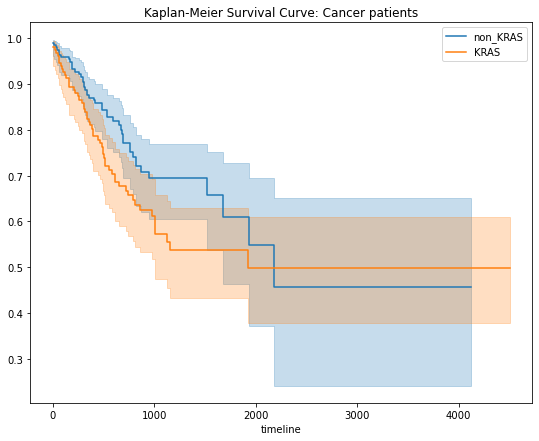

In [13]:
# import required packages
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter 
from lifelines.statistics import pairwise_logrank_test

# Initialize KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Get PFI time and PFI data from filtered CDR data
PFI_time = filtered_CDR_data['PFI.time']
PFI = filtered_CDR_data['PFI']

# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(col):
    # Create a figure object
    fig = plt.figure(figsize=[9,7])
    
    # Add a subplot to the figure
    ax = fig.add_subplot(111)
    
    # Loop through the unique values under mutation column
    for mutation in filtered_CDR_data[col].unique():
        # Get the rows for this mutation
        ix = filtered_CDR_data[col] == mutation
        
        # Fit the KaplanMeierFitter model on the data for this mutation
        kmf.fit(PFI_time[ix], PFI[ix], label=mutation)
        
        # Plot the KaplanMeierFitter model on the subplot
        kmf.plot(ax=ax, title='Kaplan-Meier Survival Curve: Cancer patients')
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
    # Run pairwise Log-rank test on the data
    log_rank = pairwise_logrank_test(filtered_CDR_data['PFI.time'], filtered_CDR_data[col], filtered_CDR_data['PFI'], bonferri=True)
    
    # Return the summary of Log-rank test
    return log_rank.summary

# Call the helper function to plot the KM curve grouping by mutation
plot_km("mutation")

# Call the helper function to get the p-value using the Log-rank test
print_logrank("mutation")


The Kaplan-Meier method is a practical technique that could contribute significantly to the production of evidence-based data on survival time. To compare the full curves of each group, the log rank test computes the chi-square (X2). The two curves are not statistically significantly different because the log rank rest for the data in our example was P = 0.058, which is not <0.05. This is probably due to the sample's small size, which makes it difficult to rule out a true difference and prevent a type 2 error (false negative). Therefore, we can conclude that there is no significant variance in survival between the two groups of patients (those with and without the KRAS mutation).